<a href="https://colab.research.google.com/github/anniey27/amath342/blob/main/HW2%3A%20Compare_neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h3> This notebook will compare tuning curves of different neurons using the Allen Brain Observatory data </h3>
    
In the first notebook, we computed the tuning curve of one neuron to the 'Drifting Gratings' stimulus. Here we will do this for many neurons so we can see the diversity of visual responses.


In [1]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

### Standard imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Allen Brain Observatory set up

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>In the last notebook we walked through computing the two dimensional tuning curve for just one neuron. Here we are going to do this for many neurons. To make this easier, begin by writing a function to compute the tuning curve, plot the heatmap, and save the figure to the results folder.
<p>You will need the get_dff_traces_and_stim_table function that we used in the previous notebook as part of this so I've provided it here:
</div>

In [4]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus):
    #identify the session for a given cell id and stimulus
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])

    #get the session_id for that session
    session_id = exps[0]['id']

    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)

    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]

    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)

    #return everything
    return (timestamps, dff_trace, stim_table)

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Write a function to compute and plot the z-score of the tuning curve for a defined cell_id. I've outlined the function you need to write below - look back at your work in the previous notebook and do some strategic copying and pasting.
</div>


In [25]:
def compute_tuning(cell_id, stimulus):
    #get the dff_traces and the stimulus table using the function above
    timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id,
                                                                      stimulus)
    #compute the cell response
    cell_response= np.zeros((len(stim_table),3))
    for i in range(len(stim_table)):
        cell_response[i,0] = stim_table.orientation[i] #orientation
        cell_response[i,1] = stim_table.temporal_frequency[i] #temporal frequency
        cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()#mean response

    # get the orivals and tfvals
    orivals = np.unique(cell_response[:, 0])
    tfvals = np.unique(cell_response[:, 1])

    # having an issue with nan/inf values, so checking if they're here and removing them
    orivals = orivals[np.isfinite(orivals)]
    tfvals = tfvals[np.isfinite(tfvals)]

    # compute the tuning array
    tuning = np.zeros((len(orivals), len(tfvals)))
    for i, ori in enumerate(orivals):
        for j, tf in enumerate(tfvals):
            trials = (cell_response[:, 0] == ori) & (cell_response[:, 1] == tf)
            tuning[i, j] = cell_response[trials, 2].mean()

    # compute the z-score
    std_tuning = np.std(tuning)
    mean_tuning = np.mean(tuning)
    tuning_z = (tuning - mean_tuning) / std_tuning

    # plot the heatmap of the tuning array
    for i, ori in enumerate(orivals):
        plt.plot(tfvals, tuning_z[i, :], label=f"Orientation {ori}°")

    plt.xlabel("Temporal Frequency (Hz)")
    plt.ylabel("Z-score")
    plt.title(f"Tuning Curve for Cell ID {cell_id}")
    plt.legend()
    plt.show()

    return tuning, tuning_z

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 2:** Test your function by computing and plotting the tuning curve for the neuron we looked at in the preious notebook, cell_id: 541513979
</div>

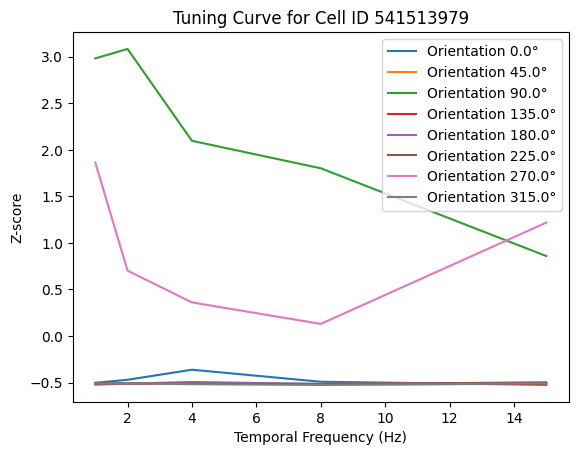

Tuning Array: [[ 5.44733334e-03  2.74314884e-02  1.00642059e-01  1.31085904e-02
  -9.33339198e-03]
 [ 2.12238663e-03  1.45389121e-03  4.68400959e-04 -2.63391312e-03
   1.02468282e-03]
 [ 2.36521010e+00  2.43408302e+00  1.76553687e+00  1.56588788e+00
   9.27463206e-01]
 [-7.45246005e-03 -1.22696266e-03  3.43910728e-03 -6.60876827e-03
  -2.16010856e-03]
 [ 2.44913390e-03 -1.24267348e-03  1.17516761e-02 -3.36494617e-03
   6.42828858e-03]
 [ 3.93892424e-03  1.04745566e-03 -8.69145006e-04 -3.08841196e-03
   7.98432483e-03]
 [ 1.60713360e+00  8.21318219e-01  5.90318163e-01  4.34047849e-01
   1.17069845e+00]
 [-4.90759404e-04  2.16914783e-03 -4.83089223e-03 -1.00003566e-02
   9.41361922e-04]]
Z-scored Tuning Array: [[-0.50207346 -0.46961536 -0.36152496 -0.49076214 -0.52389619]
 [-0.50698252 -0.5079695  -0.50942451 -0.51400487 -0.5086032 ]
 [ 2.98195483  3.08364099  2.09657832  1.80181026  0.8592199 ]
 [-0.52111912 -0.5119276  -0.50503847 -0.51987347 -0.51330533]
 [-0.5065001  -0.5119508  -0.4

In [28]:
cell_id = 541513979
tuning, tuning_z = compute_tuning(cell_id, "drifting_gratings")
print("Tuning Array:", tuning)
print("Z-scored Tuning Array:", tuning_z)

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 3:** Compute and plot the tuning curves for cell_ids 541511905, 541512490, 541512611, 541512645, 541512079, 541511403, 541511670, 541511373, 541513771, 541511385, 541512607.
(Note: these are all neurons from the same session as the neuron above)

</div>

Cell id: 541511905


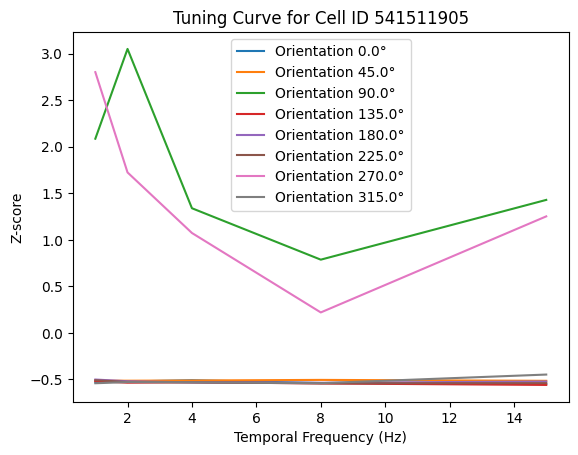

Tuning array for cell 541511905: [[-6.25190229e-04  9.88891259e-04  3.64534603e-03 -2.19411301e-03
  -4.40109842e-03]
 [ 2.61526272e-03  2.60608492e-03  3.02462610e-03  4.28814593e-03
   2.37313200e-03]
 [ 5.04936109e-01  6.91330119e-01  3.60609259e-01  2.53878877e-01
   3.77926645e-01]
 [ 1.92575903e-03 -1.53111796e-03 -4.45171942e-04 -3.09036823e-03
  -6.13845167e-03]
 [ 5.00944182e-03  1.51203848e-03 -7.76238719e-04 -1.68106352e-03
   1.00458040e-03]
 [ 3.60189762e-03  8.52541300e-05 -1.01762493e-03 -2.73199559e-03
  -2.41156897e-03]
 [ 6.43131631e-01  4.34960524e-01  3.09240567e-01  1.44340273e-01
   3.43729661e-01]
 [-2.65766166e-03 -2.51736952e-04 -6.17139006e-04 -2.50162768e-03
   1.53745132e-02]]
Z-score tuning array for cell 541511905: [[-0.53123061 -0.52287356 -0.50911952 -0.53935386 -0.55078073]
 [-0.51445287 -0.51450039 -0.51233335 -0.50579136 -0.51570652]
 [ 2.08635994  3.05143224  1.33909428  0.78648782  1.42875665]
 [-0.51802284 -0.53592114 -0.53029855 -0.5439943  -0.559

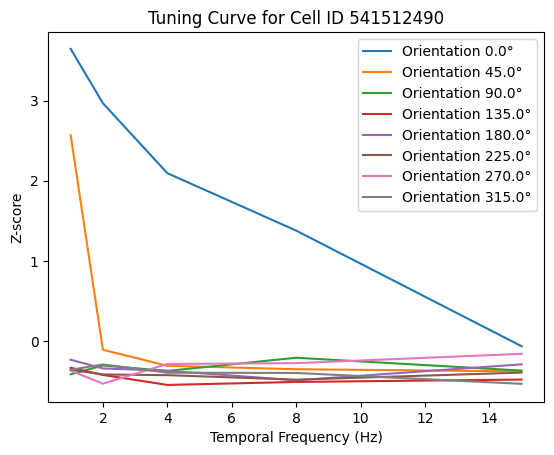

Tuning array for cell 541512490: [[ 0.1373319   0.11436284  0.08476603  0.06046607  0.0115332 ]
 [ 0.10081886  0.01004439  0.00326678  0.00181248  0.00089895]
 [-0.00035181  0.00340054  0.00109763  0.0066697   0.00123778]
 [ 0.00241081 -0.00058927 -0.0048287  -0.00357244 -0.00255812]
 [ 0.00582727  0.00214421  0.00116399 -0.00288662  0.00387655]
 [ 0.00161761 -0.00040657 -0.00069546 -0.00260297  0.00039444]
 [ 0.00120172 -0.00431443  0.00403597  0.0043793   0.00831933]
 [ 0.00159632  0.00382924  0.00034086  0.00023372 -0.00436854]]
Z-score tuning array for cell 541512490: [[ 3.64596533  2.96806154  2.09454747  1.37736356 -0.06683077]
 [ 2.56832729 -0.11077122 -0.31080416 -0.35372595 -0.3806878 ]
 [-0.41760225 -0.30685633 -0.37482377 -0.210371   -0.37068766]
 [-0.33606702 -0.42461058 -0.54973227 -0.51265538 -0.48271877]
 [-0.23523437 -0.34393544 -0.37286532 -0.49241413 -0.29280757]
 [-0.35947742 -0.41921849 -0.42774468 -0.48404265 -0.39557754]
 [-0.3717519  -0.53455417 -0.2881022  -0.27

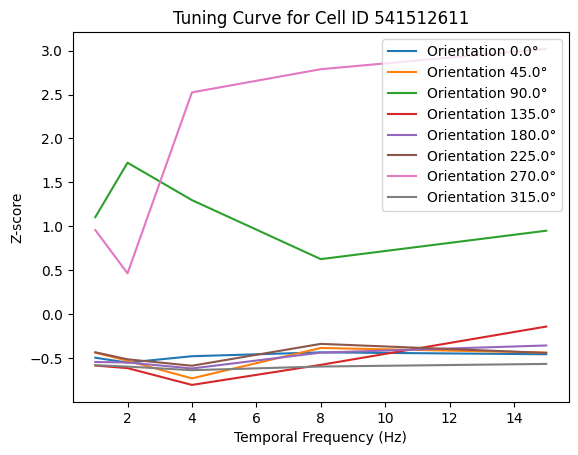

Tuning array for cell 541512611: [[ 0.00534551  0.00378699  0.00581529  0.00703661  0.0064415 ]
 [ 0.00693178  0.0043774  -0.00121902  0.00843553  0.00696809]
 [ 0.04997432  0.06724091  0.05536699  0.03663728  0.04565621]
 [ 0.00285621  0.00204158 -0.00329401  0.00307961  0.01523575]
 [ 0.00398871  0.00383308  0.001929    0.00695935  0.00923083]
 [ 0.00707139  0.00484063  0.00279732  0.0097374   0.00686882]
 [ 0.04585941  0.03211248  0.08956734  0.09692603  0.10336259]
 [ 0.00297406  0.00251987  0.00138773  0.00254743  0.00337273]]
Z-score tuning array for cell 541512611: [[-0.49560185 -0.55149406 -0.47875419 -0.43495459 -0.45629672]
 [-0.43871403 -0.53032069 -0.731022   -0.38478591 -0.43741187]
 [ 1.10489768  1.72412023  1.29829214  0.62659864  0.95003962]
 [-0.58487412 -0.61408875 -0.80543621 -0.57686251 -0.14091316]
 [-0.54426011 -0.54984112 -0.61812624 -0.43772559 -0.35626471]
 [-0.43370748 -0.513708   -0.58698616 -0.33809781 -0.44097208]
 [ 0.95732694  0.46432804  2.5248013   2.78

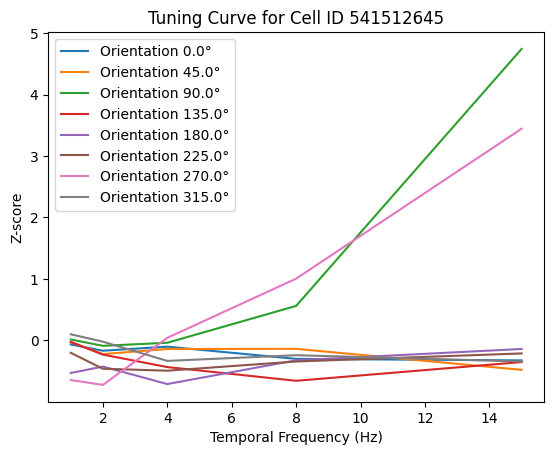

Tuning array for cell 541512645: [[ 5.85903109e-03  4.36012972e-03  5.33065944e-03  2.41546487e-03
   2.04970133e-03]
 [ 6.43006870e-03  3.55527382e-03  4.77411358e-03  4.80872139e-03
  -2.02938173e-04]
 [ 7.04067476e-03  5.53483124e-03  6.26163600e-03  1.50646622e-02
   7.64183845e-02]
 [ 6.46689802e-03  3.43804217e-03  4.56681533e-04 -2.81959093e-03
   1.65600755e-03]
 [-9.56749633e-04  5.76505911e-04 -3.59757391e-03  2.07508417e-03
   4.77976274e-03]
 [ 3.86365137e-03  6.46883156e-05 -4.05758588e-04  1.78717603e-03
   3.71639522e-03]
 [-2.62616321e-03 -3.80352019e-03  7.44013941e-03  2.15668682e-02
   5.73642502e-02]
 [ 8.29124716e-03  6.52350004e-03  1.93178519e-03  3.28569885e-03
   1.79930225e-03]]
Z-score tuning array for cell 541512645: [[-0.06507787 -0.16718347 -0.1010707  -0.2996546  -0.32457052]
 [-0.02617862 -0.22201049 -0.13898277 -0.13662527 -0.47802098]
 [ 0.01541604 -0.08716246 -0.0376523   0.56201241  4.7414459 ]
 [-0.02366979 -0.22999634 -0.4330875  -0.65626813 -0.351

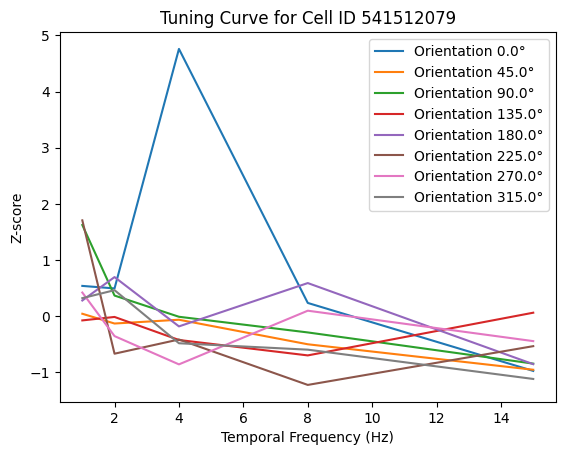

Tuning array for cell 541512079: [[ 8.02174233e-03  7.62115596e-03  4.59243895e-02  5.29775379e-03
  -5.57368669e-03]
 [ 3.56891857e-03  2.00592355e-03  2.61230413e-03 -1.31299013e-03
  -5.38527270e-03]
 [ 1.77650211e-02  6.47895938e-03  3.08639408e-03  5.80675425e-04
  -4.40537952e-03]
 [ 2.50395977e-03  3.05797814e-03 -6.25879039e-04 -3.09335374e-03
   3.73579314e-03]
 [ 5.68862132e-03  9.43410474e-03  1.54673179e-03  8.47655057e-03
  -4.49444848e-03]
 [ 1.85076362e-02 -2.82108205e-03 -5.48327132e-04 -7.81396654e-03
  -1.61443050e-03]
 [ 6.96027211e-03 -5.73484382e-06 -4.52742591e-03  4.05664022e-03
  -8.08403482e-04]
 [ 6.06304890e-03  7.33988682e-03 -1.14946770e-03 -2.17458643e-03
  -6.85894381e-03]]
Z-score tuning array for cell 541512079: [[ 0.53924389  0.49464719  4.75889141  0.23598615 -0.97431578]
 [ 0.04351739 -0.13048861 -0.06298113 -0.49997852 -0.95333992]
 [ 1.62394919  0.36748808 -0.01020137 -0.28915945 -0.84424981]
 [-0.07504295 -0.01336488 -0.42348343 -0.69818386  0.062

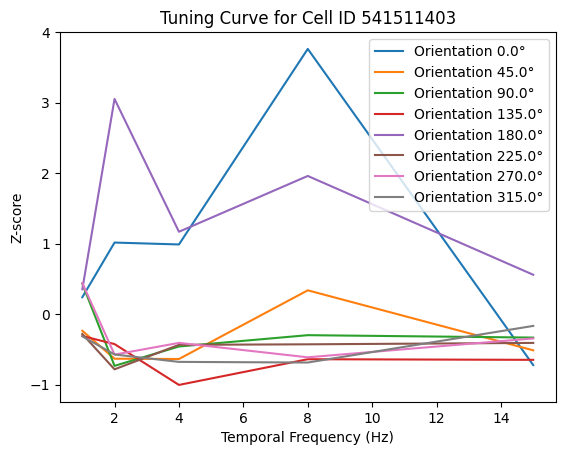

Tuning array for cell 541511403: [[ 0.01628148  0.02766754  0.0272727   0.06802176  0.00213337]
 [ 0.00928125  0.00346397  0.00340334  0.01771493  0.00521328]
 [ 0.01908858  0.0019724   0.00600627  0.0083688   0.00786638]
 [ 0.00819295  0.00651217 -0.00199897  0.0033579   0.00322858]
 [ 0.01792941  0.05760128  0.02992147  0.04154977  0.02095764]
 [ 0.00861923  0.00125384  0.00635321  0.00646298  0.00675684]
 [ 0.01923384  0.00431935  0.00676413  0.00375497  0.0076848 ]
 [ 0.00812262  0.00434542  0.00280184  0.00266705  0.01029952]]
Z-score tuning array for cell 541511403: [[ 0.23964245  1.0147471   0.98786855  3.76185552 -0.72348796]
 [-0.23689677 -0.63290741 -0.63703473  0.33722486 -0.51382332]
 [ 0.43073597 -0.73444602 -0.45984057 -0.2990119  -0.33321429]
 [-0.31098281 -0.42540203 -1.00479659 -0.64012839 -0.6489316 ]
 [ 0.35182562  3.05248255  1.16818311  1.95977852  0.55797186]
 [-0.28196381 -0.78336172 -0.43622258 -0.42875029 -0.40874598]
 [ 0.44062421 -0.57467757 -0.40824957 -0.61

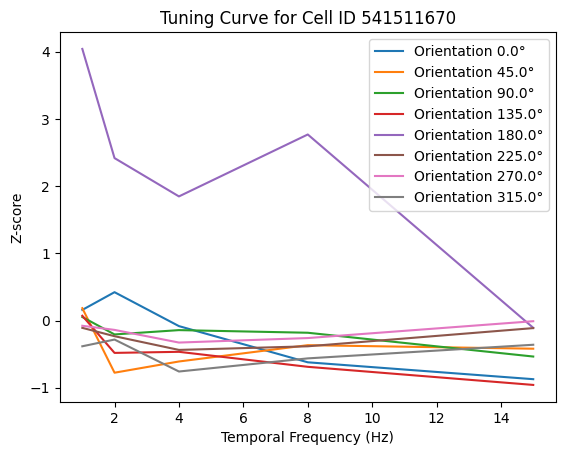

Tuning array for cell 541511670: [[ 0.00895897  0.01160572  0.00653612  0.00113082 -0.001392  ]
 [ 0.00921513 -0.00042335  0.00125259  0.00368883  0.00316159]
 [ 0.00789583  0.00529353  0.00593829  0.00554557  0.00199117]
 [ 0.00808311  0.00253514  0.00269622  0.00045438 -0.0022496 ]
 [ 0.04795051  0.03163886  0.02591441  0.03516707  0.00628393]
 [ 0.00627691  0.00502949  0.00298048  0.00352116  0.00623847]
 [ 0.00658728  0.00597216  0.0040792   0.00475164  0.00727022]
 [ 0.0035239   0.00452872 -0.00024579  0.00171624  0.00375126]]
Z-score tuning array for cell 541511670: [[ 0.15804423  0.42152293 -0.08314605 -0.62123297 -0.87237508]
 [ 0.18354381 -0.77594711 -0.60911056 -0.36658784 -0.41907382]
 [ 0.0522105  -0.20684342 -0.14265922 -0.18175316 -0.5355864 ]
 [ 0.07085393 -0.48143565 -0.46540011 -0.68857101 -0.95774701]
 [ 4.0395743   2.41578194  1.84592438  2.76700814 -0.1082506 ]
 [-0.10894942 -0.23312776 -0.43710282 -0.38327957 -0.11277615]
 [-0.0780531  -0.13928739 -0.32772792 -0.26

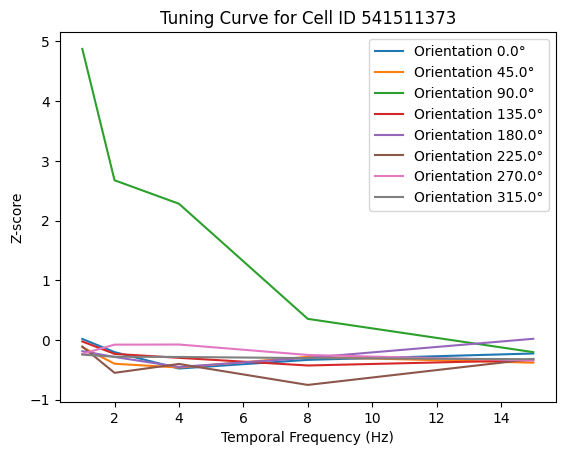

Tuning array for cell 541511373: [[ 0.00939125  0.00526543  0.00011861  0.00282894  0.00482946]
 [ 0.00680393  0.0016135   0.00042609  0.00377532  0.00193136]
 [ 0.10036853  0.05916803  0.05180212  0.01569124  0.0052518 ]
 [ 0.00859376  0.00471122  0.00346934  0.00106482  0.00273369]
 [ 0.00553978  0.00374692  0.00060123  0.00346389  0.00944021]
 [ 0.00699449 -0.00123434  0.00154776 -0.00503     0.00311085]
 [ 0.00472143  0.00760451  0.0076447   0.00436846  0.00262664]
 [ 0.00446646  0.00381487  0.00373871  0.00338593  0.00303376]]
Z-score tuning array for cell 541511373: [[ 0.0163202  -0.20398819 -0.47881553 -0.33409072 -0.22726805]
 [-0.12183609 -0.39899209 -0.46239678 -0.28355634 -0.38201891]
 [ 4.87427461  2.67427307  2.2809524   0.35272331 -0.2047159 ]
 [-0.02626405 -0.23358173 -0.29989486 -0.42829037 -0.33917682]
 [-0.18933877 -0.28507259 -0.45304482 -0.30018584  0.01893442]
 [-0.11166103 -0.55105951 -0.40250248 -0.75373812 -0.31903746]
 [-0.23303646 -0.07908751 -0.0769413  -0.25

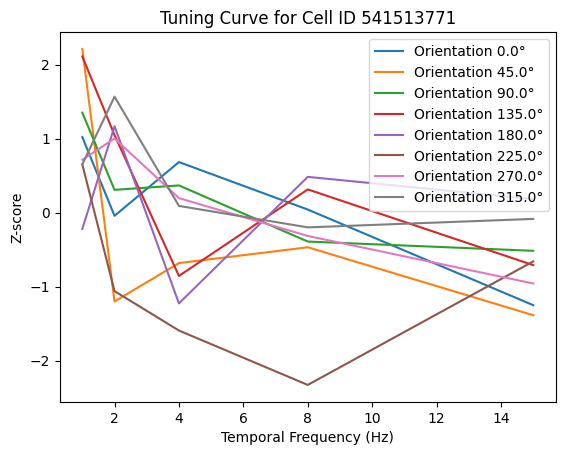

Tuning array for cell 541513771: [[ 0.00697458  0.00399732  0.00603116  0.00423392  0.00061585]
 [ 0.01031202  0.00075713  0.0022082   0.00280697  0.00023647]
 [ 0.00789911  0.00497996  0.0051468   0.00302318  0.00267304]
 [ 0.01002794  0.00705163  0.00172234  0.00499646  0.00213081]
 [ 0.00350248  0.00738555  0.00068311  0.00547113  0.00462802]
 [ 0.00594014  0.00114733 -0.00034369 -0.00240161  0.00227261]
 [ 0.00611745  0.00692359  0.00466558  0.00323505  0.0014366 ]
 [ 0.00594121  0.00850501  0.00437219  0.00355984  0.00387956]]
Z-score tuning array for cell 541513771: [[ 1.01991855 -0.04332929  0.68300127  0.04116611 -1.25093159]
 [ 2.21179613 -1.20047661 -0.68226838 -0.46843263 -1.38641579]
 [ 1.35009099  0.30759361  0.36717546 -0.39121935 -0.51626041]
 [ 2.11034422  1.04743435 -0.85577721  0.31348691 -0.70990301]
 [-0.22004879  1.1666866  -1.22691044  0.48300239  0.1819072 ]
 [ 0.6504965  -1.06112977 -1.59360668 -2.32853605 -0.65926325]
 [ 0.71381687  1.00170932  0.19532215 -0.31

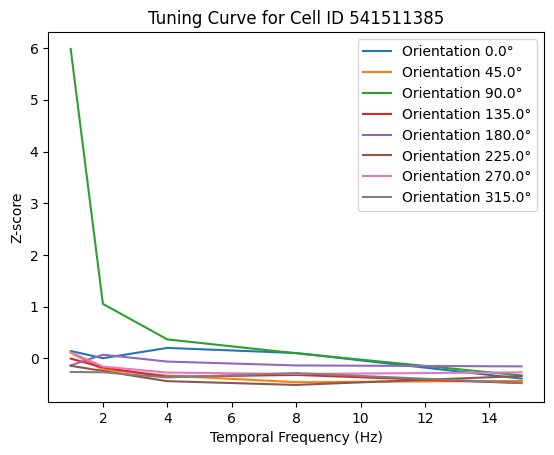

Tuning array for cell 541511385: [[ 1.05048988e-02  7.32763984e-03  1.18723540e-02  9.61484661e-03
  -1.69889940e-03]
 [ 9.76120405e-03  2.27794187e-03 -3.62813893e-04 -3.27068766e-03
  -2.72830201e-03]
 [ 1.43993516e-01  3.13163281e-02  1.56250886e-02  9.50464749e-03
  -2.98336043e-04]
 [ 7.14981207e-03  3.22149137e-03 -8.86899617e-04 -6.13602965e-05
  -3.68663236e-03]
 [ 4.15426026e-03  8.88082172e-03  5.83486983e-03  4.12657567e-03
   3.71397188e-03]
 [ 3.97315081e-03  1.68123441e-03 -2.82670048e-03 -4.48329824e-03
  -5.33271043e-04]
 [ 9.95567706e-03  3.61856488e-03  9.78061755e-04  3.45460706e-04
   1.07248830e-03]
 [ 1.25186775e-03  1.09784191e-03 -1.16267990e-03  7.33566630e-04
  -3.62181260e-03]]
Z-score tuning array for cell 541511385: [[ 1.44579317e-01  5.61908208e-03  2.04386181e-01  1.05652096e-01
  -3.89164606e-01]
 [ 1.12053168e-01 -2.15233931e-01 -3.30729723e-01 -4.57908158e-01
  -4.34186441e-01]
 [ 5.98282224e+00  1.05478561e+00  3.68515352e-01  1.00832440e-01
  -3.2790

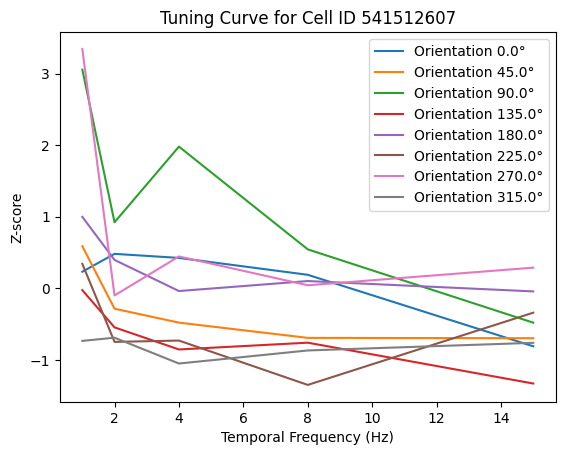

Tuning array for cell 541512607: [[ 6.20223970e-03  7.75536670e-03  7.40226518e-03  5.93639329e-03
  -2.69308174e-04]
 [ 8.41929315e-03  2.99409148e-03  1.78452788e-03  4.61906654e-04
   4.32922711e-04]
 [ 2.37441259e-02  1.04971493e-02  1.70629248e-02  8.14336345e-03
   1.78271559e-03]
 [ 4.60391896e-03  1.37360928e-03 -5.44596085e-04  4.47291071e-05
  -3.50042180e-03]
 [ 1.09693267e-02  7.22708931e-03  4.52664969e-03  5.39381643e-03
   4.49467208e-03]
 [ 6.88734618e-03  1.14378403e-04  2.27454010e-04 -3.62243887e-03
   2.64771066e-03]
 [ 2.55443970e-02  4.14411487e-03  7.53055459e-03  5.02714741e-03
   6.55760721e-03]
 [ 1.99208993e-04  4.77480452e-04 -1.76577471e-03 -6.31408343e-04
   3.28570651e-05]]
Z-score tuning array for cell 541512607: [[ 0.23239654  0.4822686   0.4254605   0.18962631 -0.8087669 ]
 [ 0.58908323 -0.28374067 -0.47833915 -0.69112671 -0.69578974]
 [ 3.05459161  0.92337541  1.97969848  0.54469077 -0.47863072]
 [-0.02474644 -0.54444906 -0.8530561  -0.75824357 -1.328

In [29]:
def plot_tuning_curves(cell_ids, stimulus):
    for cell_id in cell_ids:
        print(f"Cell id: {cell_id}")
        tuning, tuning_z = compute_tuning(cell_id, stimulus)
        print(f"Tuning array for cell {cell_id}:", tuning)
        print(f"Z-score tuning array for cell {cell_id}:", tuning_z)

cell_ids = [541511905, 541512490, 541512611, 541512645, 541512079, 541511403,
            541511670, 541511373, 541513771, 541511385, 541512607]
plot_tuning_curves(cell_ids, 'drifting_gratings')

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
What are some things you notice when looking at these? What are some of the ways different neurons have different tuning curves?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>All of the neurons we've looked at so far are from just one session. This means they are all from a single population of neurons in a specific mouse, that has a specific genotype and age, and that were recorded from a single brain region and a single imaging depth (i.e. cortical layer).
<p>Let's see what these details are for this session. Begin by accessing the dataset for this session, starting with our orignal cell_id. We will use the same functions from the AllenSDK that are hidden in our get_dff_traces_and_stim_table function.
</div>

In [30]:
cell_id = 541513979
session_id = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>We can access metadata about this session using a function called `get_metadata`
<p>
</div>

In [31]:
metadata = data_set.get_metadata()

This is a dictionary with some metadata describing this experiment. Let's see what the `keys` of the dictionary are.

In [32]:
metadata.keys()

dict_keys(['sex', 'targeted_structure', 'ophys_experiment_id', 'experiment_container_id', 'excitation_lambda', 'indicator', 'fov', 'genotype', 'session_start_time', 'session_type', 'specimen_name', 'cre_line', 'imaging_depth_um', 'age_days', 'device', 'device_name', 'pipeline_version'])

We can use this to pull some experimental details about the experiment

In [33]:
print("Mouse sex: ", metadata['sex'])
print("Mouse age: ", metadata['age_days'])
print("Mouse genotype: ", metadata["genotype"])
print("Brain region: ", metadata["targeted_structure"])
print("Imaging depth: ", metadata["imaging_depth_um"])

Mouse sex:  male
Mouse age:  121
Mouse genotype:  Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Brain region:  VISp
Imaging depth:  175


What does this mean?
<p>We recorded from a male mouse in the brain region called "VISp". This is the primary visual cortex (sometimes called "V1").
<p>The imaging depth is 175 um, which maps to layer 2/3 of the cortex.
<p>And the genotype of the mouse is a jumble of letters. The first part "Emx1-IRES-Cre" is the Cre driver that is driving the expression of the reporter in a particular subset of neurons. In this case, Emx is a pan-excitatory driver, driving expression in all excitatory neurons, but not inhibitory interneurons. What is it driving? Camk2a-tTA and Ai93(TITL-GCaMP6f). Ai93 is GCaMP6f, a genetically encoded calcium indicator. Camk2a-tTA acts to amplify the expression of Ai93. In this mouse, all excitatory neurons in cortex are expressing GCaMP6f.
<p>So the neurons we are recording in this experiment are excitatory neurons in layer 2/3 of VISp.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>In the entire Allen Brain Observatory dataset, we recorded from ~250 mice, sampling from 14 different transgenic lines (i.e. cell types), 6 cortical areas, and 4 different cortical layers. This allows us to compare responses of neurons across all these dimensions. So let's compare these Emx responses we've been looking at with some responses from neurons of different cell types in VISp.
<p>The AllenSDK functions that we've been using to access our dataset allow us to use some of these metadata to identify sessions. Let's find sessions where neurons in VISp were recorded from other cell types.
<p>We will look at responses from `Vip-IRES-Cre`, `Sst-IRES-Cre`, and `Pvalb-IRES-Cre`. These are three different types of inhibitory interneurons. As such they are much sparser than the Emx neurons are, so a given session often has a small number of neurons in it (say roughly a dozen) while the Emx session we were looking at before has over 200 neurons. We will just plot the tuning curves for all of the neurons in these experiments.
</div>

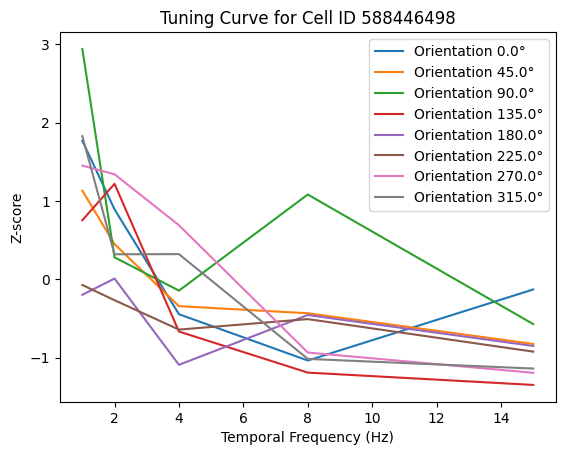

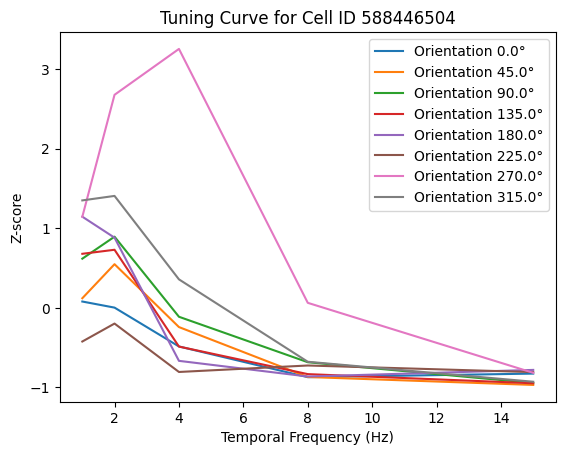

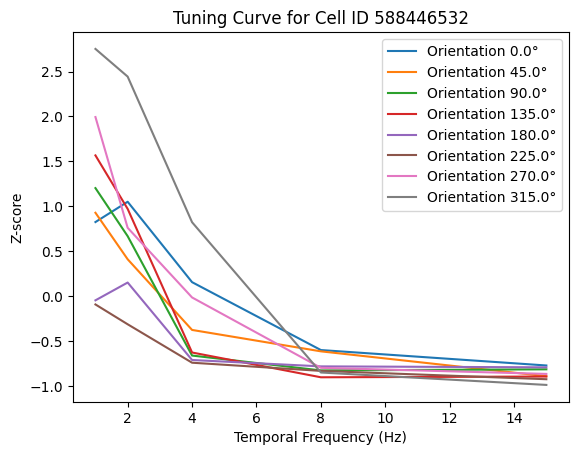

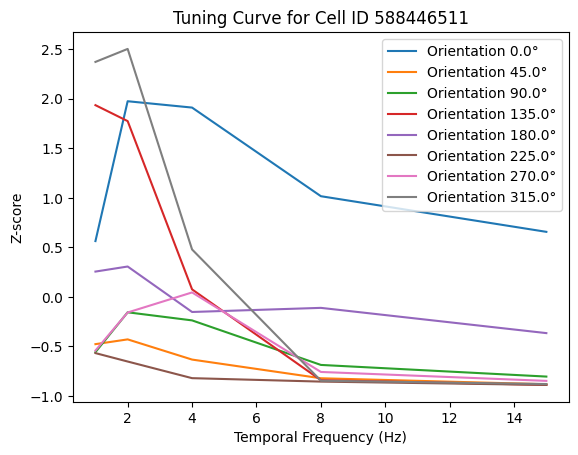

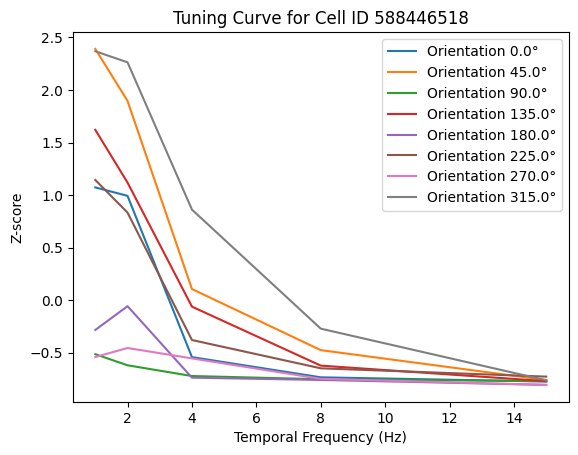

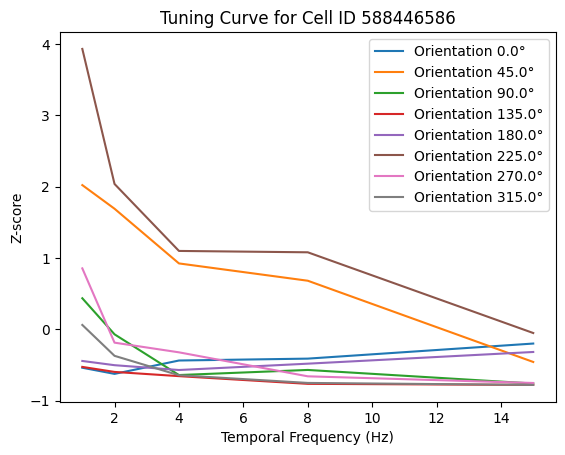

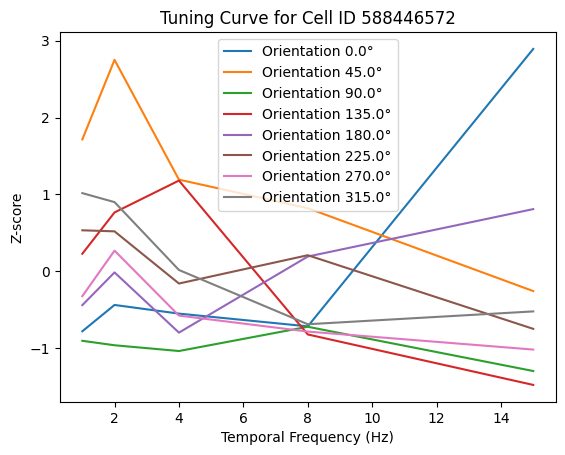

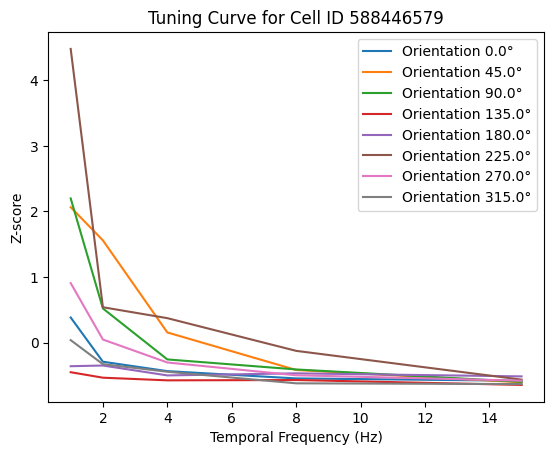

In [34]:
#first we select a session with Sst-IRES-Cre in VISp when drifting gratings are presented. There are several such experiment and we'll just pull the first one (index 0).
session_id = boc.get_ophys_experiments(cre_lines=['Sst-IRES-Cre'], targeted_structures=['VISp'], stimuli=['drifting_gratings'])[0]['id']
#next get the dataset for this session
data_set = boc.get_ophys_experiment_data(session_id)
#last plot the tuning curve for all the neurons in this session
for cell_id in data_set.get_cell_specimen_ids():
    compute_tuning(cell_id, 'drifting_gratings')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 4:**  Repeat the same thing for `Pvalb-IRES-Cre`. (Copy the code above an[link text](https://)d replace the "Sst-IRES-Cre" with "Pvalb-IRES-Cre")</div>

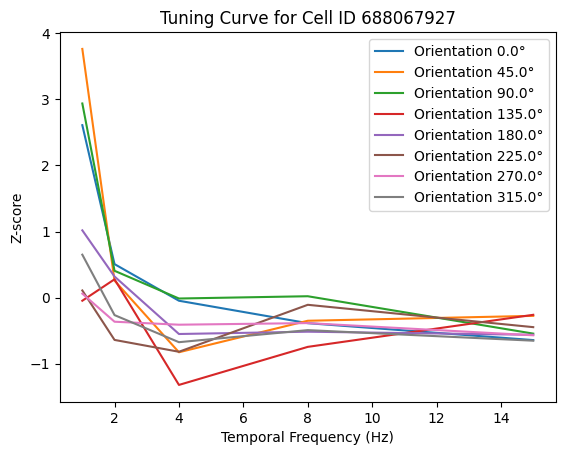

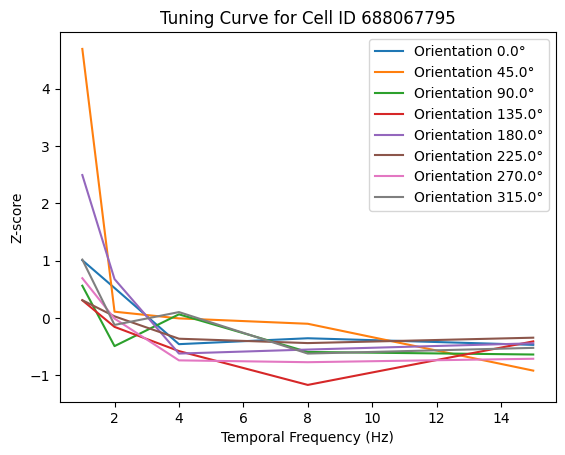

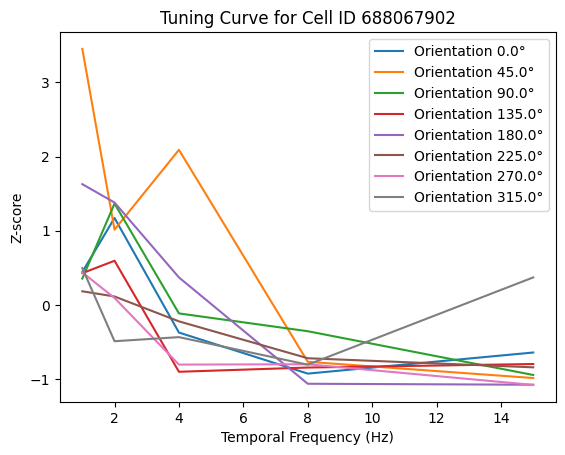

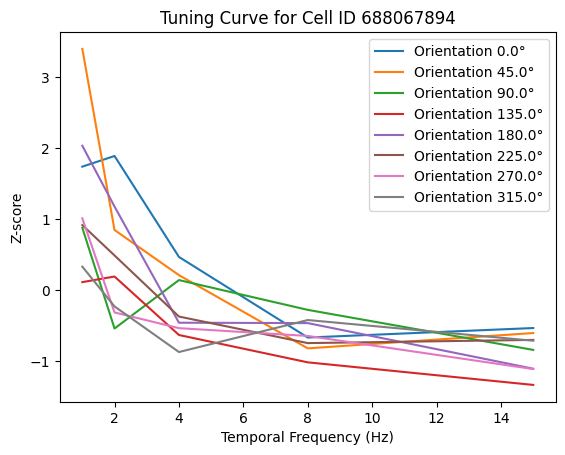

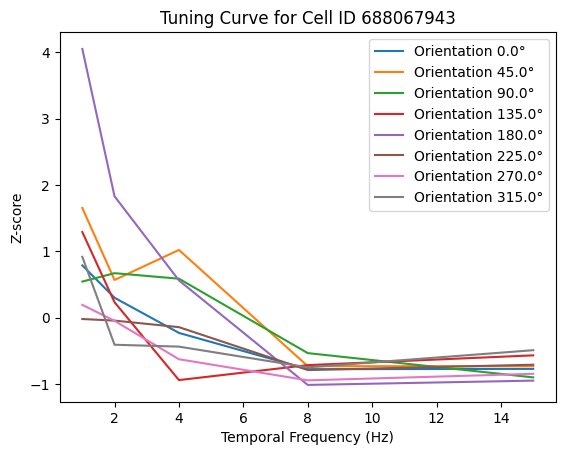

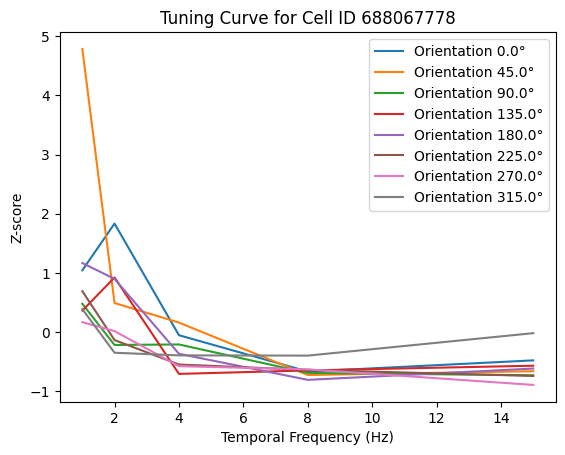

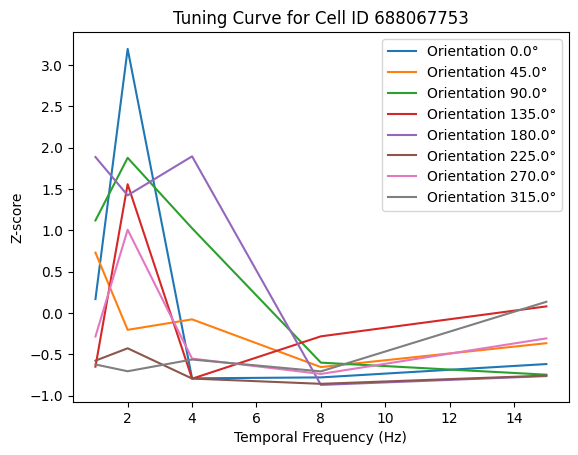

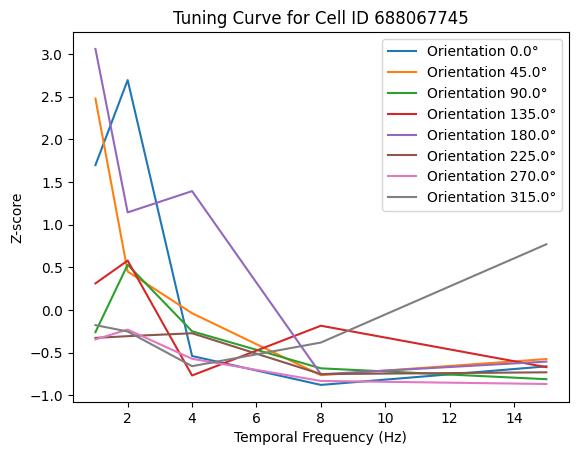

In [35]:
session_id = boc.get_ophys_experiments(cre_lines=['Pvalb-IRES-Cre'], targeted_structures=['VISp'], stimuli=['drifting_gratings'])[0]['id']
#next get the dataset for this session
data_set = boc.get_ophys_experiment_data(session_id)
#last plot the tuning curve for all the neurons in this session
for cell_id in data_set.get_cell_specimen_ids():
    compute_tuning(cell_id, 'drifting_gratings')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 5:** Repeat the same thing for `Vip-IRES-Cre`. </div>

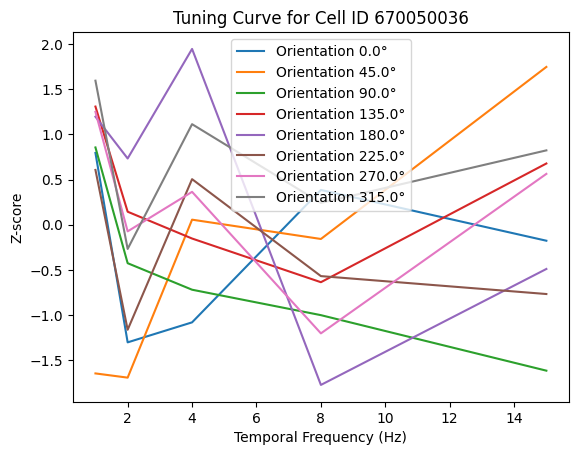

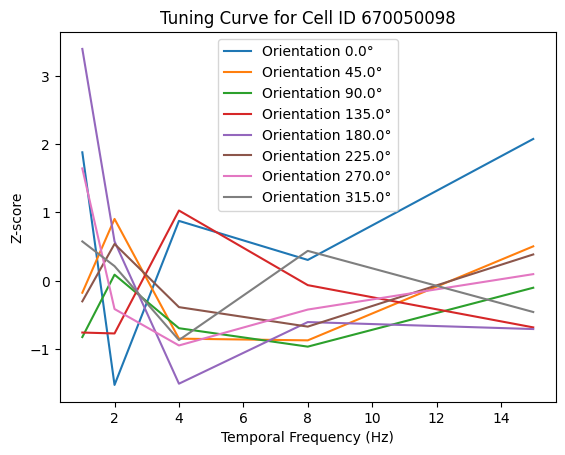

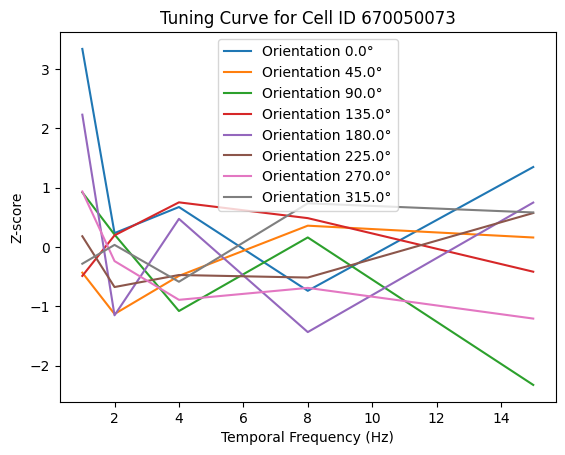

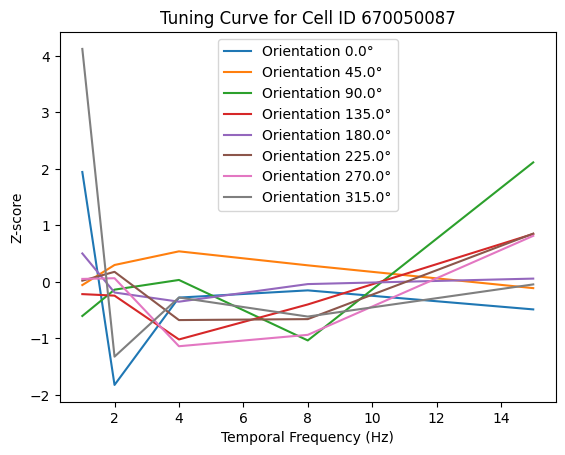

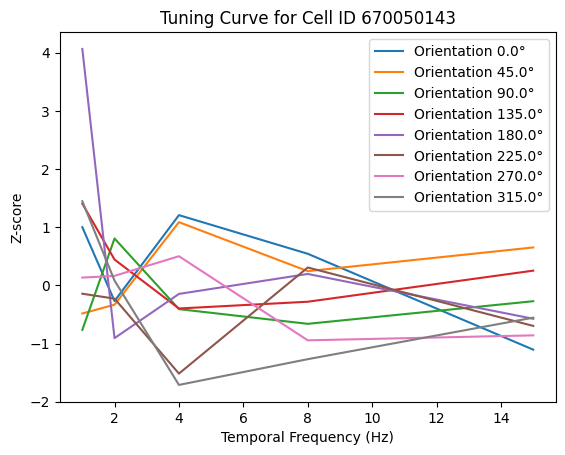

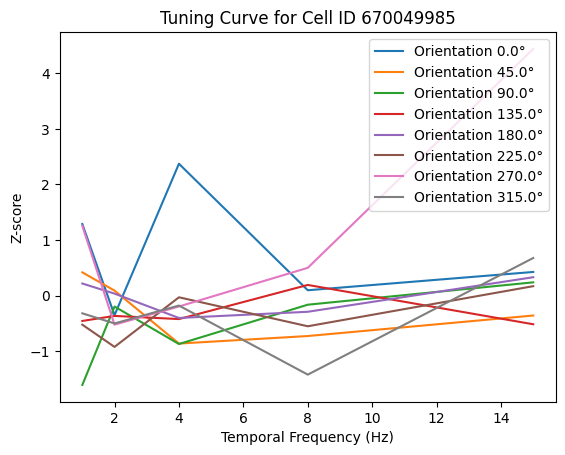

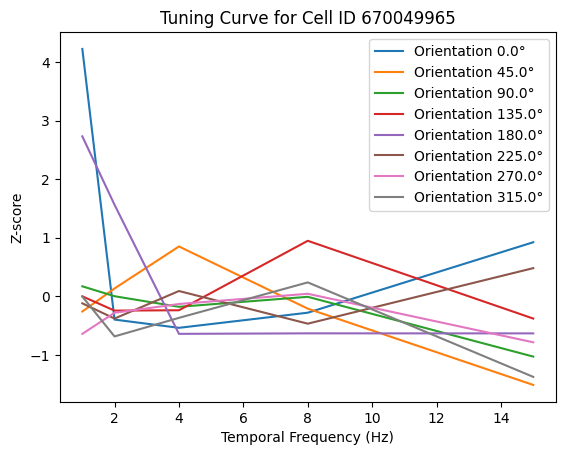

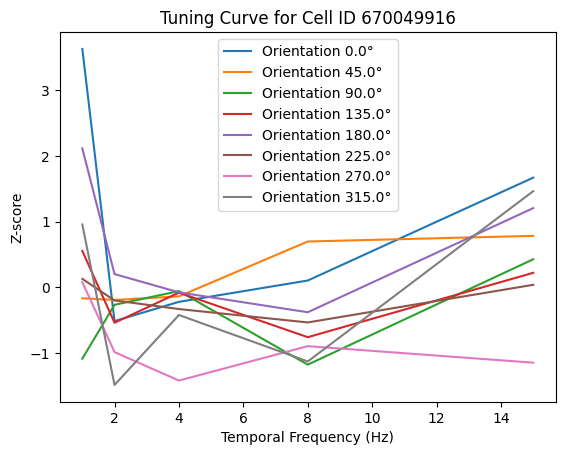

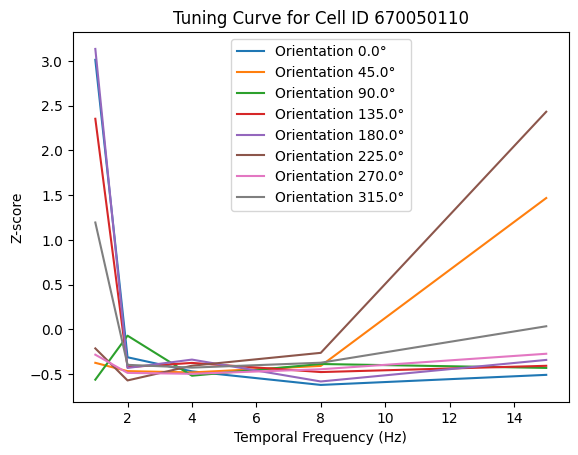

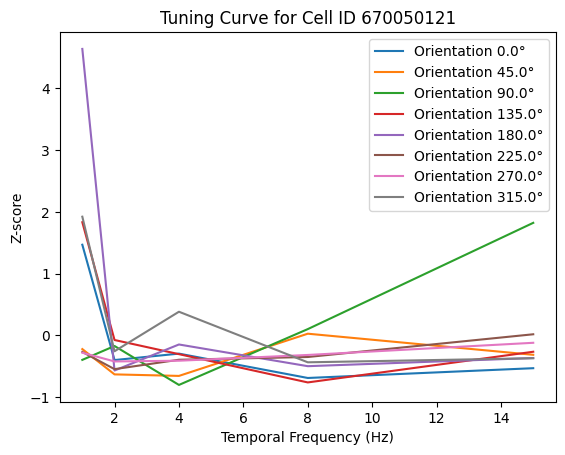

In [36]:
session_id = boc.get_ophys_experiments(cre_lines=['Vip-IRES-Cre'], targeted_structures=['VISp'], stimuli=['drifting_gratings'])[0]['id']
#next get the dataset for this session
data_set = boc.get_ophys_experiment_data(session_id)
#last plot the tuning curve for all the neurons in this session
for cell_id in data_set.get_cell_specimen_ids():
    compute_tuning(cell_id, 'drifting_gratings')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>What do you notice about these tuning curves for the inhibitory interneurons? In what ways do they look similar to the Emx cells? In what ways do they **look** different? How consistent are the responses within each inhibitory population? Are the tuning curves of the different types of inhibitory interneurons similar to each other? </div>

Pvalb-IRES-Cre was the most consistent among its tuning curves. There was a general pattern of a steep decrease towards the beginning before tapering off. This suggests that this inhibitory interneuron is more stable and well defined. The next most consistent would be Sst-IRES-Cre as I can also see a pattern of a steep decrease towards the beginning and then leveling. However, there are still some inconsistent tuning curves in the mix, showing signs of lack of structure. Vip-IRES-Cre is the most inconsistent interneuron as its cells' tuning curves are very undefined and lack structure or pattern.